# Modeling

## 0. Load-data, Data-preprocessing, Remove-outlier

In [624]:
import pandas as pd

train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
submission_raw = pd.read_csv("data/submission.csv")

train = train_raw.copy()
test = test_raw.copy()
submission = submission_raw.copy()

In [125]:
# 결측치 채우기, 시계열 데이터일 것이라고 추측하므로 이전 값을 사용하였음
train = train.fillna(method="ffill")
# train = train.fillna(0)

In [126]:
# 단위 조정
train['hour_bef_visibility'] = train['hour_bef_visibility']/10
train['hour_bef_ozone'] = train['hour_bef_ozone']*10

In [154]:
from sklearn.model_selection import train_test_split

# data allocate, id 값과 편향된 값을 가진 변수, 그리고 집단 간의 두드러진 차이가 나타나지 않은 변수는 제거하였다.
X = train.drop(['id', 'count', 'hour_bef_precipitation', 'hour_bef_pm2.5'], axis=1)
y = train['count']
features = X.columns

# train -> train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.1, shuffle=False)

print(f"X_train.shape : {X_train.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"X_valid.shape : {X_valid.shape}")
print(f"y_valid.shape : {y_valid.shape}")
print("features :", features.tolist())

X_train.shape : (1313, 7)
y_train.shape : (1313,)
X_valid.shape : (146, 7)
y_valid.shape : (146,)
features : ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone', 'hour_bef_pm10']


## 1. Linear Regression

In [208]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
lr = LinearRegression()

In [209]:
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[ 4.64985357  5.34153624  3.57860762 -0.44656622  0.05421251 27.42259427
 -0.27554177]
-21.78607254662566


In [157]:
# 양의 계수를 갖는 변수들
X.columns[lr.coef_>0].tolist()

['hour',
 'hour_bef_temperature',
 'hour_bef_windspeed',
 'hour_bef_visibility',
 'hour_bef_ozone']

In [158]:
# 음의 계수를 갖는 변수들
X.columns[lr.coef_<0].tolist()

['hour_bef_humidity', 'hour_bef_pm10']

### RMSE

In [210]:
from sklearn.metrics import mean_squared_error

y_pred = lr.predict(X_valid)
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE

44.04674449338443

In [227]:
# 더 자세한 분석을 위해 ols 방식의 회귀 모델을 적합
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     256.7
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          3.98e-240
Time:                        20:52:58   Log-Likelihood:                -7100.6
No. Observations:                1313   AIC:                         1.422e+04
Df Residuals:                    1305   BIC:                         1.426e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -21.7861     16.268     -1.339      0.181     -53.701      10.129
hour                     4.6499      0.257     18.098      0.000       4.146       5.154
hour_bef_temperature     5.3415      0.375     14.233      0.000       4.605       6.078
hour_bef_windspeed       3.5786      1.377      2.599      0.009       0.877       6.280
hour_bef_humidity       -0.4466      0.121     -3.693      0.000      -0.684      -0.209
hour_bef_visibility      0.0542      0.039      1.391      0.164      -0.022       0.131
hour_bef_ozone          27.4226      9.810      2.796      0.005       8.178      46.667
hour_bef_pm10           -0.2755      0.057     -4.871      0.000      -0.387      -0.165
==============================================================================
Omnibus:                      152.964   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.636
Skew:                           0.815   Prob(JB):                     2.50e-52
Kurtosis:                       4.298   Cond. No.                     1.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Prob (F-statistic):	3.98e-240
    - 통계적으로 유의미한 모델로 보인다.
- 각각의 t-test
    - bias와 가시성에 대한 p-value가 0.05보다 크게 나타난다. 
- R-squared:            0.579
    - 학습 데이터의 약 58%가 회귀 모형에 의해 설명된다.
- Durbin-Watson:        1.970
    - 2에 가까운 값이 나타나므로 데이터에 자기상관성이 드러나지 않음.

In [228]:
# RMSE
y_pred = results.predict(sm.add_constant(X_valid))
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE

44.046744493384416

### Check Multicollinearity by VIF

In [238]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
def feature_engineering_XbyVIF(X_train):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i)
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    return vif

vif = feature_engineering_XbyVIF(X_train)
print(vif)

   VIF_Factor               Feature
0    5.282181                  hour
1   14.683067  hour_bef_temperature
2    6.724061    hour_bef_windspeed
3    3.789334     hour_bef_humidity
4    6.131442   hour_bef_visibility
5    8.049116        hour_bef_ozone
6    3.858840         hour_bef_pm10


In [203]:
vif = feature_engineering_XbyVIF(X_train.drop(['hour_bef_temperature'], axis=1))
print(vif)

   VIF_Factor              Feature
0    4.873365                 hour
1    6.685528   hour_bef_windspeed
2    3.565704    hour_bef_humidity
3    4.971097  hour_bef_visibility
4    6.577384       hour_bef_ozone
5    3.688209        hour_bef_pm10


- 기온에 대한 VIF값이 10을 넘기 때문에 다중공선성이 있다고 볼 수 있다. 기온 변수를 제외한 결과 가시성과 오존에 대한 VIF값이 떨어진 것으로 보아 두 변수와의 상관관계가 있는 것으로 보인다.
- 앞선 EDA의 결과 가시성과 오존보다 기온에 따른 대여 횟수의 차이가 두드러지게 드러났으므로 오존과 기온 변수를 제외하고 회귀모형을 적합해보았다.

In [236]:
vif = feature_engineering_XbyVIF(X_train.drop(['hour_bef_ozone', 'hour_bef_visibility'], axis=1))
print(vif)

   VIF_Factor               Feature
0    5.255889                  hour
1    9.336676  hour_bef_temperature
2    5.706223    hour_bef_windspeed
3    3.708210     hour_bef_humidity
4    3.710307         hour_bef_pm10


In [240]:
results = sm.OLS(y_train, sm.add_constant(X_train.drop(['hour_bef_ozone', 'hour_bef_visibility'], axis=1))).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     355.6
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          9.83e-241
Time:                        20:56:34   Log-Likelihood:                -7105.1
No. Observations:                1313   AIC:                         1.422e+04
Df Residuals:                    1307   BIC:                         1.425e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.5100     10.180     -0.247      0.805     -22.481      17.461
hour                     4.6752      0.257     18.166      0.000       4.170       5.180
hour_bef_temperature     5.5923      0.351     15.922      0.000       4.903       6.281
hour_bef_windspeed       4.7516      1.317      3.609      0.000       2.168       7.335
hour_bef_humidity       -0.5733      0.090     -6.359      0.000      -0.750      -0.396
hour_bef_pm10           -0.3051      0.047     -6.466      0.000      -0.398      -0.213
==============================================================================
Omnibus:                      146.580   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.866
Skew:                           0.799   Prob(JB):                     6.64e-49
Kurtosis:                       4.225   Cond. No.                         573.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Prob (F-statistic):	9.83e-241
    - 통계적으로 유의미한 모델로 보인다.
- 각각의 t-test
    - bias에 대한 p-value가 0.05보다 크게 나타난다. 
- R-squared:            0.576
    - 학습 데이터의 약 58%가 회귀 모형에 의해 설명된다.
- Durbin-Watson:        1.962
    - 2에 가까운 값이 나타나므로 데이터에 자기상관성이 드러나지 않는다.

In [234]:
# RMSE
y_pred = results.predict(sm.add_constant(X_valid.drop(['hour_bef_ozone', 'hour_bef_visibility'], axis=1)))
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE

44.856464735620946

## Polynomial Regression

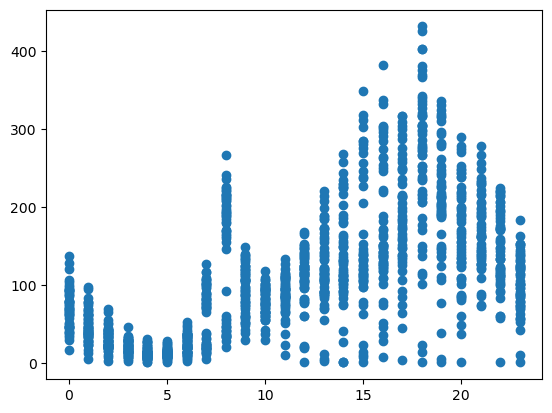

In [136]:
import matplotlib.pyplot as plt

plt.scatter(X_train['hour'], y_train)

In [243]:
import numpy as np

X_train2 = X_train.drop(['hour_bef_ozone', 'hour_bef_visibility'], axis=1).copy()
X_train2['hour_sq'] = np.power(X_train['hour'], 2)
X_train2['hour_qd'] = np.power(X_train['hour'], 3)
X_valid2 = X_valid.drop(['hour_bef_ozone', 'hour_bef_visibility'], axis=1).copy()
X_valid2['hour_sq'] = np.power(X_valid['hour'], 2)
X_valid2['hour_qd'] = np.power(X_valid['hour'], 3)


In [241]:
results = sm.OLS(y_train, sm.add_constant(X_train2)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     281.5
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          1.54e-255
Time:                        20:57:17   Log-Likelihood:                -7064.8
No. Observations:                1313   AIC:                         1.415e+04
Df Residuals:                    1305   BIC:                         1.419e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   47.7016     11.558      4.127      0.000      25.027      70.376
hour                   -13.5440      2.166     -6.252      0.000     -17.794      -9.294
hour_bef_temperature     4.3060      0.374     11.512      0.000       3.572       5.040
hour_bef_windspeed      -0.6506      1.417     -0.459      0.646      -3.431       2.129
hour_bef_humidity       -0.5032      0.088     -5.710      0.000      -0.676      -0.330
hour_bef_pm10           -0.2957      0.046     -6.454      0.000      -0.386      -0.206
hour_sq                  2.2127      0.245      9.037      0.000       1.732       2.693
hour_qd                 -0.0657      0.007     -9.086      0.000      -0.080      -0.052
==============================================================================
Omnibus:                      162.611   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.347
Skew:                           0.778   Prob(JB):                     3.00e-67
Kurtosis:                       4.783   Cond. No.                     3.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Prob (F-statistic):	1.54e-255
    - 통계적으로 유의미한 모델로 보인다.
- 각각의 t-test
    - 풍속에 대한 p-value가 0.05보다 크게 나타난다. 
- R-squared:            0.602
    - 학습 데이터의 약 60%가 회귀 모형에 의해 설명된다.
- Durbin-Watson:        1.934
    - 2에 가까운 값이 나타나므로 데이터에 자기상관성이 드러나지 않음.

In [244]:
# RMSE
y_pred = results.predict(sm.add_constant(X_valid2))
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE    # new record!

43.21753597429719

## 시계열분석
데이터가 동일한 시간마다 주기적으로 관측되지 않았기 때문에 시계열 데이터라고 보기 어렵다.

## 포아송 회귀분석

In [249]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Poisson

model = GLM(y_train, sm.add_constant(X_train), family=Poisson())
results = model.fit()
display(results.summary())

predict = results.predict(sm.add_constant(X_train))
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(predict.to_numpy()[:10])
print('---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------\n')
print(y_train.to_numpy()[:10])

# RMSE
y_pred = results.predict(sm.add_constant(X_valid))
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE    # new record!

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                 1313
Model:                            GLM   Df Residuals:                     1305
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20959.
Date:                Mon, 13 Feb 2023   Deviance:                       33885.
Time:                        21:02:36   Pearson chi2:                 3.64e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.2785      0.030    109.578      0.000       3.220       3.337
hour                     0.0526      0.000    107.960      0.000       0.052       0.054
hour_bef_temperature     0.0506      0.001     75.481      0.000       0.049       0.052
hour_bef_windspeed       0.0437      0.002     18.299      0.000       0.039       0.048
hour_bef_humidity       -0.0049      0.000    -22.724      0.000      -0.005      -0.004
hour_bef_visibility      0.0003   7.65e-05      3.649      0.000       0.000       0.000
hour_bef_ozone           0.0309      0.018      1.714      0.087      -0.004       0.066
hour_bef_pm10           -0.0023      0.000    -20.644      0.000      -0.003      -0.002
========================================================================================
"""

----------------------예측된 데이터의 상위 10개의 값 확인--------------------

[102.76656283 107.17580906  50.15192253 101.10436119 366.94418099
  40.98097941  39.04208463 183.77097357  57.56543254 112.54854742]
---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------

[ 49. 159.  26.  57. 431.  39.  23. 146.  39.  83.]


40.2907406350708

## Machine-Learning Model

### RandomForest

In [302]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=213)
model.fit(sm.add_constant(X_train), y_train)

# 학습된 모델을 이용해 결괏값 예측 후 상위 10개의 값 확인
predict = model.predict(sm.add_constant(X_valid))
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(predict[:10])
print('---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------\n')
print(y_valid.to_numpy()[:10])

# RMSE
y_pred = model.predict(sm.add_constant(X_valid))
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE    # new record!

----------------------예측된 데이터의 상위 10개의 값 확인--------------------

[ 32.71 129.19  71.7   55.45  82.35  16.2   88.6   65.37  66.38  63.36]
---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------

[31. 98. 90. 47. 99. 16. 88. 82. 55. 40.]


33.20660254738093

In [276]:
X_test = test.drop(['id', 'hour_bef_precipitation', 'hour_bef_pm2.5'], axis=1)
X_test = X_test.fillna(method="ffill")
submission['count'] = model.predict(sm.add_constant(X_test))
submission.to_csv("result1.csv", index=False)

### XGBoost

In [303]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 213)
model.fit(X_train,y_train, eval_set=[(X_valid,y_valid)],
          eval_metric = 'rmse',
          early_stopping_rounds=10,
          verbose= True
          )

# 학습된 모델을 이용해 결괏값 예측 후 상위 10개의 값 확인
predict = model.predict(X_valid)
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(predict[:10])
print('---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------\n')
print(y_valid.to_numpy()[:10])

# RMSE
y_pred = model.predict(X_valid)
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE

[0]	validation_0-rmse:95.52713
[1]	validation_0-rmse:70.89509
[2]	validation_0-rmse:57.70493
[3]	validation_0-rmse:48.69091
[4]	validation_0-rmse:43.87430
[5]	validation_0-rmse:40.80807
[6]	validation_0-rmse:39.19287
[7]	validation_0-rmse:38.94128
[8]	validation_0-rmse:38.20774
[9]	validation_0-rmse:38.06294
[10]	validation_0-rmse:38.12572
[11]	validation_0-rmse:38.51284
[12]	validation_0-rmse:38.71447
[13]	validation_0-rmse:38.80055
[14]	validation_0-rmse:39.06053
[15]	validation_0-rmse:38.58485
[16]	validation_0-rmse:38.53317
[17]	validation_0-rmse:38.50725
[18]	validation_0-rmse:38.67092
----------------------예측된 데이터의 상위 10개의 값 확인--------------------

[ 24.818466 123.305214  45.45403   44.383022  72.010864  15.936726
  98.44718   43.233948  66.93943   48.493286]
---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------

[31. 98. 90. 47. 99. 16. 88. 82. 55. 40.]


c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


38.0629405238962

## Deep-learning Model

In [666]:
import torch
from torch import nn
import torch.nn.functional as f
from torch.utils.data import DataLoader     # 데이터로더는 데이터셋을 iterable하게 감싸는 역할
from torchvision import datasets            # 데이터셋은 샘플과 정답을 저장함
from torchvision.transforms import ToTensor # 데이터셋을 텐서로 바꾸는듯?
import numpy as np
import pandas as pd


In [751]:
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
submission_raw = pd.read_csv("data/submission.csv")

In [1108]:
train = train_raw.copy()
test = test_raw.copy()
submission = submission_raw.copy()
train = train.fillna(method="ffill")
test = test.fillna(method="ffill")
train['hour_bef_visibility'] = train['hour_bef_visibility']/10
train['hour_bef_ozone'] = train['hour_bef_ozone']*10

In [1109]:
X = train.drop(['id', 'count', 'hour_bef_precipitation', 'hour_bef_pm2.5'], axis=1)
y = train['count']

normalized_X = (X-X.mean())/(X.std())

# train -> train/validation
X_train, X_valid, y_train, y_valid = train_test_split(normalized_X, y, test_size=0.1, shuffle=False)

X_tensor = torch.tensor(X_train.values).type(torch.float)
y_tensor = torch.tensor(y_train.values).type(torch.float).view(-1, 1)
print(X_tensor.shape, y_tensor.shape)

torch.Size([1313, 7]) torch.Size([1313, 1])


In [1110]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module): # nn.Module을 상속, 
    def __init__(self):         # 모델에서 사용할 레이어를 정의하는 부분
        super().__init__()      # 부모 클래스의 초기화 부분을 호출
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            # nn.Linear(7, 8),
            # nn.ReLU(),
            # nn.Linear(8, 1),
            # nn.Linear(4, 1),
        )

    def forward(self, x):   # 데이터가 들어오면 forward함수를 실행하고 결과를 반환
        result = self.linear_relu_stack(x.type(torch.float))
        return result

model = NeuralNetwork().to(device)  # model을 initialize하는 부분
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [1111]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=4e-3)    # Stochastic Gradient Descent 을 최적화 함수로 사용

In [1112]:
def train(X_tensor, y_tensor, model, loss_fn, optimizer):   # train, 모델의 파라미터를 갱신하는 알고리즘을 설계
    size = len(X_tensor)
    model.train()                           # 모델을 학습 모드로 전환, 평가 모드(eval())가 존재
    for i in range(size):
        X, y = X_tensor[i].to(device), y_tensor[i].to(device)   # Tensor data에 사용하고자 하는 device를 지정

        # Compute prediction error
        pred = model(X)
        # if pred == np.nan: break
        loss = loss_fn(pred, y) # loss 함수 또한 initiate가 필요

        # Backpropagation
        optimizer.zero_grad()   # 반복마다 기울기를 새로 계산하므로 0으로 초기화가 필요
        loss.backward()         # 최종 손실값에 backpropagation 방법을 활용하여 각 파라미터에 대한 기울기값을 계산
        optimizer.step()        # 계산한 기울기를 바탕을 가중치, 파라미터를 갱신 
        #*** loss함수의 결과를 model의 파라미터를 갖고있는 optimizer에서 활용
        #*** loss함수는 model과 관련 없어 보이나 backpropagation을 하는 것으로 보아 
        #       model의 각 레이어의 결과 데이터를 알고 있는 듯

        if i % 100 == 0:    # 100번째마다 결과를 출력
            loss, current = loss.item(), i
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [1113]:
def test(X_tensor, y_tensor, model, loss_fn):
    size = len(X_tensor)
    model.eval()                    # 모델을 평가 모드로 전환
    test_loss = 0       # 배치별 결과에서 나타난 손실의 평균을 구하는 test_loss, 정답률을 구하는 correct
    with torch.no_grad():           # 학습을 시키지 않게끔 기울기를 구하지 않는다는 것을 명시
        for i in range(size):     
            X, y = X_tensor[i].to(device), y_tensor[i].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    print(f"Test Error: \n Avg loss: {test_loss/size:>8f} \n")

In [1114]:
epochs = 12
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(X_tensor, y_tensor, model, loss_fn, optimizer)
    test(X_tensor, y_tensor, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 48.547043  [    0/ 1313]
loss: 101.118584  [  100/ 1313]
loss: 107.789963  [  200/ 1313]
loss: 106.439011  [  300/ 1313]
loss: 202.847153  [  400/ 1313]
loss: 208.999725  [  500/ 1313]
loss: 31.419762  [  600/ 1313]
loss: 92.737144  [  700/ 1313]
loss: 5.583529  [  800/ 1313]
loss: 62.745689  [  900/ 1313]
loss: 1.954606  [ 1000/ 1313]
loss: 56.286373  [ 1100/ 1313]
loss: 13.784386  [ 1200/ 1313]
loss: 41.732086  [ 1300/ 1313]
Test Error: 
 Avg loss: 39.796412 

Epoch 2
-------------------------------
loss: 35.573410  [    0/ 1313]
loss: 58.228104  [  100/ 1313]
loss: 48.143677  [  200/ 1313]
loss: 15.154999  [  300/ 1313]
loss: 75.096985  [  400/ 1313]
loss: 134.401184  [  500/ 1313]
loss: 12.164089  [  600/ 1313]
loss: 72.321991  [  700/ 1313]
loss: 3.097435  [  800/ 1313]
loss: 43.634262  [  900/ 1313]
loss: 1.885697  [ 1000/ 1313]
loss: 43.800102  [ 1100/ 1313]
loss: 20.717476  [ 1200/ 1313]
loss: 12.657875  [ 1300/ 1313]
Test Error: 
 

In [1115]:
X_tensor = torch.tensor(X_valid.values).type(torch.float).to(device)

# 학습된 모델을 이용해 결괏값 예측 후 상위 10개의 값 확인
predict = model(X_tensor)
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(predict[:10])
print('---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------\n')
print(y_valid.to_numpy()[:10])

# RMSE
y_pred = model(X_tensor).cpu().detach().numpy() 
RMSE = mean_squared_error(y_valid, y_pred, squared=False)
RMSE

----------------------예측된 데이터의 상위 10개의 값 확인--------------------

tensor([[ 42.5036],
        [106.3341],
        [ 68.9256],
        [ 29.1136],
        [ 87.4126],
        [ 29.5714],
        [ 87.7720],
        [ 19.7088],
        [ 68.0045],
        [ 31.4007]], device='cuda:0', grad_fn=<SliceBackward0>)
---------------------- 실제 데이터의 상위 10개의 값 확인 --------------------

[31. 98. 90. 47. 99. 16. 88. 82. 55. 40.]


39.67566959573948

In [1118]:
X_test = test_raw.drop(['id', 'hour_bef_precipitation', 'hour_bef_pm2.5'], axis=1)
X_test = X_test.fillna(method="ffill")
X_test = (X_test-X_test.mean())/(X_test.std())
X_tensor = torch.tensor(X_test.values).type(torch.float).to(device)
submission['count'] = model(X_tensor).cpu().detach().numpy()
submission['count']
submission.to_csv("result2.csv", index=False)

In [1117]:
submission.describe()

,id,count
count,715.000000,715.000000
mean,1056.854545,100.907410
std,625.574471,69.708748
min,0.000000,1.206093
25%,507.000000,33.641579
50%,1046.000000,87.009171
75%,1616.500000,162.211983
max,2177.000000,286.155457
